## Logistic Regression

Logistic regression is a simple machine learning algorithm for classification. It computes the weighted sum of its inputs and outputs an *activation* that turns the weighted sum into fixed interval (here: [0,1]). This allows us to interpret the logistic regression output as the probability of being of a class or not.
In this toy example we are going to use it to decide, to which of two distributions a data point belongs.

### Setup

For a detailed explanation of the used modules, please refer to the respective sections in the [introductory notebook](0_MNIST_dataset.ipynb).

In [21]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(842424)

### Generation of Artificial Data

First we generate some artificial data for our toy model to learn on.
The task is to predict to which normal distributions one individual data point belongs.

In [22]:
def generate_data(n_samples=1000, input_dim=2):
    """
    Return coordinates distributed in 2D space by two different gaussian distributions.
    
    Returns
    -------
    x : np.array[n_samples, input_dim]
        coordinates
    y : np.array[n_samples]
        labels
    """
    half_samples = n_samples // 2
    
    # generate the blobs
    x1 = np.random.normal(1., 0.25, size=(half_samples, input_dim))
    x2 = np.random.normal(2., 0.30, size=(half_samples, input_dim))
    
    # create matching labels
    y1 = np.zeros(half_samples)
    y2 = np.ones(half_samples)
    
    return np.concatenate((x1, x2)), np.concatenate((y1, y2))

data, labels = generate_data()
data.shape, labels.shape

((1000, 2), (1000,))

We shuffle the data to improve covergence behaviour and to more closely emulate real data.

In [23]:
shuffled_indices = np.arange(data.shape[0])
np.random.shuffle(shuffled_indices)

data, labels = data[shuffled_indices], labels[shuffled_indices]

And plot the points colored by label.

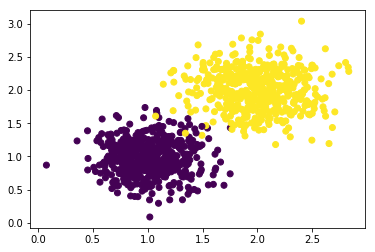

In [38]:
def plot_data(data, labels):
    """
    Plot data colored by labels.
    
    Parameters
    ----------
    data : np.array[n_samples, input_dim]
    labels : np.array[input_dim]
    """
    plt.scatter(data[:, 0], data[:, 1], c=labels, vmin=0.0, vmax=1.0)
    plt.show()
    
plot_data(data, labels)

### The Logistic Function
The logistic (or sigmoid) function gives the predicted probability of the tested hypothesis being true.
In our case: does the input belong to the yellow distribution?

$$\sigma(z) = \frac{1}{1 + \text{e}^{-z}}$$

The activation function of a neuron is applied to the dot product of the weights of the model and the input.
To optimize the model with a gradient descent optimizer, the activation function has to be differentiable.

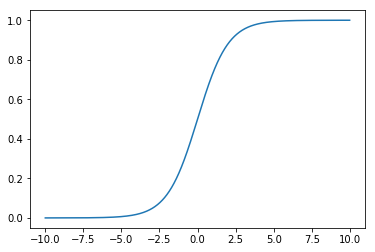

In [25]:
def sigmoid(z):
    """Return the sigmoid of input z."""
    return 1.0 / (1.0 + np.exp(-z))

def plot_sigmoid():
    """
    Plot sigmoid function from -10 to 10.
    """
    plot_range = np.arange(-10, 10, 0.01)
    plt.plot(plot_range, sigmoid(plot_range))
    plt.show()
    
plot_sigmoid()

### Logistic Regression Model

The logistic regression is a very simple linear model. It encodes a single straight line (in 2D). Everything beyond the line does not belong to the class.

In the multiclass case, one simply trains multiple models.

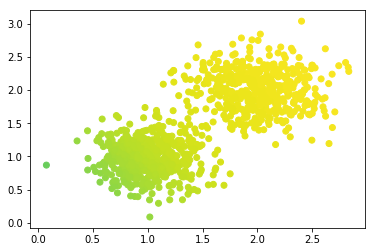

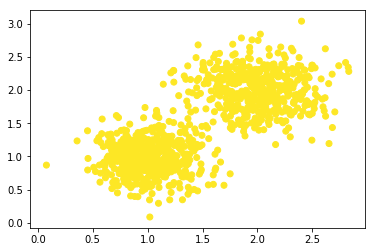

In [33]:
def lr_predict(weights, x):
    """
    Return the prediction of the model for input x with the given weights.
    
    Parameters
    ----------
    weights: the weights of the model to be learned. There is one weight for every input dimension plus a bias.
    x: input data where the 0th input should be 1.0 to take the bias into account in a simple dot product.
    
    Returns:
    ----------
    The activation of the logistic regression, in this case the sigmoid of the dot product of weights and input.
    """
    return sigmoid(np.dot(x, weights))

weights = np.random.rand(data.shape[1] + 1)

ones = np.ones((data.shape[0], 1,))
plot_data(data, lr_predict(weights, np.hstack([ones, data])))
plot_data(data, np.around(lr_predict(weights, np.hstack([ones, data]))))

### The Loss Function

The loss function measures how well the model performs. If the model predicts all samples correctly it would be 0.
Here we use Mean Squared Error:

$$ MSE(\textrm{samples}) = \frac{1}{2 |\textrm{samples}|} \sum_{x \in \textrm{samples}} \left(\hat{y}(x) - y_{\textrm{label}}\right)^2$$

To minimize the loss, we also compute the gradient w.r.t. a single weight.

$$ \nabla = (\hat{y}(x) - y_{\textrm{label}}) \cdot y(x)^2 \cdot \textrm{e}^{-w \cdot x} \cdot x$$

where the weight vector is $w$ with the bias $w_0$.

In [34]:
def lr_loss(weights, x, label):
    """Return the loss and the gradient with respect to the weights.
    
    Parameters
    ----------
    weights : weights of the model to be learned, where weights[0] is the bias
    x : single input sample, x[0] is assumed to be 1
    label : label belonging to x
    
    Returns
    -----------
    loss : mean square error loss for a single sample
    gradient : np.array([weights.shape]) 
        gradient of loss with respect to labels
    """
    loss = 0.
    features = x.shape[0]
    
    y = lr_predict(weights, x)
    
    loss = (y - label) ** 2 / 2
    gradient = (y - label) * y ** 2 * np.exp(-np.dot(weights, x)) * x
    
    return loss, gradient

lr_loss(weights, np.concatenate([[1], data[0]]), labels[0])

(0.0002771048488776904, array([-0.00054116, -0.00109572, -0.00109671]))

### Training the Model Manually
To train the model, we first initialize the weights (plus bias) and compute the corresponding loss.
To comfortably incorporate the bias, prepend $x_0 = 1$ to the input data so you can just compute the dot product in the functions above.
We then update the weights with the gradient of the loss, until the model converges.
Since loss is not a very intuitable quantity, we also print the accuracy (percentage of correctly classified samples).

In [28]:
def lr_train(weights, x, labels, epochs=100, lr=0.001):
    """
    Train the model, i.e. update the weights following the negative gradient until the model converges.
    """
    n_samples = x.shape[0]
    ones = np.ones((n_samples, 1,))
    x = np.hstack([ones, x])
    
    for epoch in range(epochs):
        loss_sum = 0.0
        accuracy = 0.0
        
        for n in range(n_samples):
            loss, gradient = lr_loss(weights, x[n], labels[n])
            loss_sum += loss
            
            if int(lr_predict(weights, x[n]) + 0.5) == labels[n]:
                accuracy += 1.0
            weights -= lr * gradient

        loss_sum /= n_samples
        accuracy /= n_samples
        accuracy *= 100
        
        # print every tenth epoch the training status
        if epoch % 10 == 0:
            print('Epoch: {:2}, Loss: {:.5f}, Accuracy: {}'.format(epoch, loss_sum, accuracy))
            
    return weights

weights = lr_train(weights, data, labels)

Epoch:  0, Loss: 0.15957, Accuracy: 50.0
Epoch: 10, Loss: 0.10560, Accuracy: 51.0
Epoch: 20, Loss: 0.09602, Accuracy: 64.5
Epoch: 30, Loss: 0.08766, Accuracy: 78.0
Epoch: 40, Loss: 0.08030, Accuracy: 87.2
Epoch: 50, Loss: 0.07386, Accuracy: 92.80000000000001
Epoch: 60, Loss: 0.06824, Accuracy: 94.8
Epoch: 70, Loss: 0.06331, Accuracy: 97.0
Epoch: 80, Loss: 0.05899, Accuracy: 97.6
Epoch: 90, Loss: 0.05519, Accuracy: 97.89999999999999


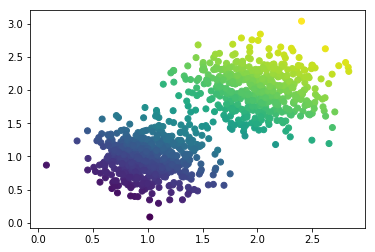

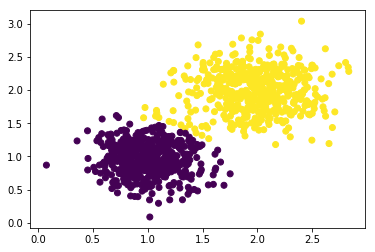

In [29]:
ones = np.ones((data.shape[0], 1,))
plot_data(data, lr_predict(weights, np.hstack([ones, data])))
plot_data(data, np.around(lr_predict(weights, np.hstack([ones, data]))))